# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://deep-learning-su.github.io/assignment-requirements/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from deep_learning_su.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'deep_learning_su/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **deep_learning_su/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file deep_learning_su/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from deep_learning_su.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.326474
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** I think it is because when our model is not trained, the possibility of each class is almost equal - in our case that possibility is 1/10 = 0.1.

In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from deep_learning_su.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.250831 analytic: 1.250830, relative error: 3.642509e-08
numerical: 1.112393 analytic: 1.112393, relative error: 1.047594e-08
numerical: -1.459371 analytic: -1.459371, relative error: 4.335828e-08
numerical: -6.262799 analytic: -6.262799, relative error: 5.801558e-09
numerical: -0.058668 analytic: -0.058668, relative error: 1.235049e-06
numerical: 0.152755 analytic: 0.152755, relative error: 1.756642e-07
numerical: 0.103206 analytic: 0.103206, relative error: 1.057516e-07
numerical: -0.068235 analytic: -0.068236, relative error: 5.835960e-07
numerical: -0.275819 analytic: -0.275819, relative error: 1.891874e-08
numerical: -0.484552 analytic: -0.484552, relative error: 1.813127e-08
numerical: -0.599964 analytic: -0.599965, relative error: 1.212998e-07
numerical: -0.625917 analytic: -0.625917, relative error: 8.651558e-08
numerical: -1.874768 analytic: -1.874768, relative error: 1.813716e-08
numerical: 3.218269 analytic: 3.218269, relative error: 1.526035e-08
numerical: 0.618

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from deep_learning_su.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.326474e+00 computed in 0.379555s
vectorized loss: 2.326474e+00 computed in 0.014135s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from deep_learning_su.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in np.linspace(learning_rates[0], learning_rates[1], num=10):
    for reg in np.linspace(regularization_strengths[0], regularization_strengths[1], num=10):
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate, reg, num_iters=1500,
                                  verbose=True)
        
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[learning_rate, reg] = training_accuracy, validation_accuracy
        
        if(validation_accuracy > best_val):
            best_val = validation_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 774.473019
iteration 100 / 1500: loss 468.823508
iteration 200 / 1500: loss 284.196468
iteration 300 / 1500: loss 172.771420
iteration 400 / 1500: loss 105.297166
iteration 500 / 1500: loss 64.491071
iteration 600 / 1500: loss 39.936079
iteration 700 / 1500: loss 24.987558
iteration 800 / 1500: loss 15.963899
iteration 900 / 1500: loss 10.491749
iteration 1000 / 1500: loss 7.160453
iteration 1100 / 1500: loss 5.219558
iteration 1200 / 1500: loss 3.958625
iteration 1300 / 1500: loss 3.238314
iteration 1400 / 1500: loss 2.775982
iteration 0 / 1500: loss 859.845943
iteration 100 / 1500: loss 491.694717
iteration 200 / 1500: loss 281.992824
iteration 300 / 1500: loss 162.112968
iteration 400 / 1500: loss 93.631512
iteration 500 / 1500: loss 54.487946
iteration 600 / 1500: loss 32.019578
iteration 700 / 1500: loss 19.261054
iteration 800 / 1500: loss 11.981399
iteration 900 / 1500: loss 7.681780
iteration 1000 / 1500: loss 5.360393
iteration 1100 / 1500: loss 3.9389

iteration 1200 / 1500: loss 2.174336
iteration 1300 / 1500: loss 2.196460
iteration 1400 / 1500: loss 2.195561
iteration 0 / 1500: loss 1206.930991
iteration 100 / 1500: loss 390.432090
iteration 200 / 1500: loss 127.532850
iteration 300 / 1500: loss 42.677123
iteration 400 / 1500: loss 15.286152
iteration 500 / 1500: loss 6.330265
iteration 600 / 1500: loss 3.538968
iteration 700 / 1500: loss 2.593963
iteration 800 / 1500: loss 2.335896
iteration 900 / 1500: loss 2.209039
iteration 1000 / 1500: loss 2.128429
iteration 1100 / 1500: loss 2.181268
iteration 1200 / 1500: loss 2.091326
iteration 1300 / 1500: loss 2.121680
iteration 1400 / 1500: loss 2.151199
iteration 0 / 1500: loss 1284.549339
iteration 100 / 1500: loss 383.598704
iteration 200 / 1500: loss 115.767800
iteration 300 / 1500: loss 36.001700
iteration 400 / 1500: loss 12.325281
iteration 500 / 1500: loss 5.200125
iteration 600 / 1500: loss 3.091091
iteration 700 / 1500: loss 2.450689
iteration 800 / 1500: loss 2.222111
iterat

iteration 1100 / 1500: loss 2.149227
iteration 1200 / 1500: loss 2.229100
iteration 1300 / 1500: loss 2.120472
iteration 1400 / 1500: loss 2.203010
iteration 0 / 1500: loss 764.225375
iteration 100 / 1500: loss 236.916757
iteration 200 / 1500: loss 74.724469
iteration 300 / 1500: loss 24.427677
iteration 400 / 1500: loss 9.047813
iteration 500 / 1500: loss 4.266115
iteration 600 / 1500: loss 2.782401
iteration 700 / 1500: loss 2.274925
iteration 800 / 1500: loss 2.212529
iteration 900 / 1500: loss 2.117870
iteration 1000 / 1500: loss 2.108252
iteration 1100 / 1500: loss 2.095559
iteration 1200 / 1500: loss 2.041518
iteration 1300 / 1500: loss 2.103965
iteration 1400 / 1500: loss 2.101634
iteration 0 / 1500: loss 849.891991
iteration 100 / 1500: loss 231.262792
iteration 200 / 1500: loss 64.118506
iteration 300 / 1500: loss 18.927066
iteration 400 / 1500: loss 6.679734
iteration 500 / 1500: loss 3.422755
iteration 600 / 1500: loss 2.363187
iteration 700 / 1500: loss 2.168995
iteration 8

iteration 1000 / 1500: loss 2.132010
iteration 1100 / 1500: loss 2.131232
iteration 1200 / 1500: loss 2.191061
iteration 1300 / 1500: loss 2.250158
iteration 1400 / 1500: loss 2.215503
iteration 0 / 1500: loss 1214.735893
iteration 100 / 1500: loss 139.153453
iteration 200 / 1500: loss 17.685710
iteration 300 / 1500: loss 3.884941
iteration 400 / 1500: loss 2.300353
iteration 500 / 1500: loss 2.194573
iteration 600 / 1500: loss 2.202745
iteration 700 / 1500: loss 2.132625
iteration 800 / 1500: loss 2.107778
iteration 900 / 1500: loss 2.149368
iteration 1000 / 1500: loss 2.130263
iteration 1100 / 1500: loss 2.132138
iteration 1200 / 1500: loss 2.155318
iteration 1300 / 1500: loss 2.095556
iteration 1400 / 1500: loss 2.173440
iteration 0 / 1500: loss 1267.026269
iteration 100 / 1500: loss 124.498806
iteration 200 / 1500: loss 14.016646
iteration 300 / 1500: loss 3.345859
iteration 400 / 1500: loss 2.269692
iteration 500 / 1500: loss 2.154841
iteration 600 / 1500: loss 2.140720
iteration 

iteration 1000 / 1500: loss 2.213352
iteration 1100 / 1500: loss 2.237022
iteration 1200 / 1500: loss 2.159075
iteration 1300 / 1500: loss 2.149688
iteration 1400 / 1500: loss 2.142036
iteration 0 / 1500: loss 772.242138
iteration 100 / 1500: loss 122.998873
iteration 200 / 1500: loss 21.134573
iteration 300 / 1500: loss 5.089352
iteration 400 / 1500: loss 2.615104
iteration 500 / 1500: loss 2.186021
iteration 600 / 1500: loss 2.097350
iteration 700 / 1500: loss 2.080132
iteration 800 / 1500: loss 2.117519
iteration 900 / 1500: loss 2.182359
iteration 1000 / 1500: loss 2.107522
iteration 1100 / 1500: loss 2.064542
iteration 1200 / 1500: loss 2.121225
iteration 1300 / 1500: loss 2.041248
iteration 1400 / 1500: loss 2.186525
iteration 0 / 1500: loss 849.772610
iteration 100 / 1500: loss 110.357417
iteration 200 / 1500: loss 16.020336
iteration 300 / 1500: loss 3.899508
iteration 400 / 1500: loss 2.352316
iteration 500 / 1500: loss 2.168129
iteration 600 / 1500: loss 2.080679
iteration 70

iteration 1000 / 1500: loss 2.155857
iteration 1100 / 1500: loss 2.160067
iteration 1200 / 1500: loss 2.130722
iteration 1300 / 1500: loss 2.149805
iteration 1400 / 1500: loss 2.166230
iteration 0 / 1500: loss 1208.102377
iteration 100 / 1500: loss 49.746938
iteration 200 / 1500: loss 4.006985
iteration 300 / 1500: loss 2.268195
iteration 400 / 1500: loss 2.186660
iteration 500 / 1500: loss 2.183196
iteration 600 / 1500: loss 2.173306
iteration 700 / 1500: loss 2.155447
iteration 800 / 1500: loss 2.192339
iteration 900 / 1500: loss 2.189728
iteration 1000 / 1500: loss 2.152933
iteration 1100 / 1500: loss 2.181426
iteration 1200 / 1500: loss 2.168329
iteration 1300 / 1500: loss 2.199555
iteration 1400 / 1500: loss 2.130962
iteration 0 / 1500: loss 1280.880328
iteration 100 / 1500: loss 42.173918
iteration 200 / 1500: loss 3.456391
iteration 300 / 1500: loss 2.182451
iteration 400 / 1500: loss 2.165574
iteration 500 / 1500: loss 2.272505
iteration 600 / 1500: loss 2.118447
iteration 700 

iteration 1000 / 1500: loss 2.192373
iteration 1100 / 1500: loss 2.166961
iteration 1200 / 1500: loss 2.106492
iteration 1300 / 1500: loss 2.187994
iteration 1400 / 1500: loss 2.160915
iteration 0 / 1500: loss 775.387906
iteration 100 / 1500: loss 63.773285
iteration 200 / 1500: loss 7.079299
iteration 300 / 1500: loss 2.508487
iteration 400 / 1500: loss 2.119511
iteration 500 / 1500: loss 2.164326
iteration 600 / 1500: loss 2.070277
iteration 700 / 1500: loss 2.064794
iteration 800 / 1500: loss 2.072973
iteration 900 / 1500: loss 2.100921
iteration 1000 / 1500: loss 2.122651
iteration 1100 / 1500: loss 2.131531
iteration 1200 / 1500: loss 2.132283
iteration 1300 / 1500: loss 2.171164
iteration 1400 / 1500: loss 2.095797
iteration 0 / 1500: loss 871.884680
iteration 100 / 1500: loss 54.423073
iteration 200 / 1500: loss 5.294054
iteration 300 / 1500: loss 2.320777
iteration 400 / 1500: loss 2.111642
iteration 500 / 1500: loss 2.116239
iteration 600 / 1500: loss 2.111457
iteration 700 / 

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.367000


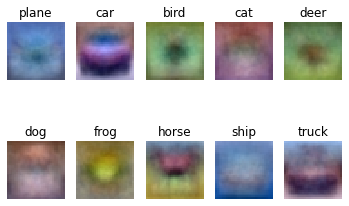

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])